<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/zeroshot/sam%2Bzeroshot%2Broom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grounding DINO Installation

In [1]:
import os
HOME = os.getcwd()
print(HOME)
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

%cd {HOME}/GroundingDINO

/content
/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 267 (delta 18), reused 16 (delta 16), pack-reused 226
Receiving objects: 100% (267/267), 12.33 MiB | 19.76 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8

Semantic Anything Installation

In [2]:
# transformers install
!pip install git+https://github.com/huggingface/transformers.git
# SAM install
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-hk3j8y3z
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hk3j8y3z
  Resolved https://github.com/huggingface/transformers.git to commit 4060d6857e12b8ad76e7562cf5146263a04f23ca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.29.0.dev0-py3-none-any.whl size=6962388 sha256=d2174d552a2090e1586d7d3b34fc8ea51fcc46d57368a0577ec6e8e68a0aacf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-p1w5873d/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da38ef3226e127ebea86ee
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.1
    Uninstalling t

Pipeline

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

import pycocotools.mask as mask_util
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [6]:
# load grounding DINO zero shot object detection
import os
HOME = "/content"
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)

detection_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def postprocess_for_downstream_task_coarse(boxes, w_threshold=0.6, h_threshold=0.6):
  post_boxes = []
  for idx, box in enumerate(boxes.cpu().numpy().tolist()):
    if (box[2] < w_threshold and box[3] < h_threshold):
      post_boxes.append(box)
  ppost_boxes = []
  for post_box in post_boxes:
    xmin = post_box[0] - post_box[2] * 0.5
    xmax = post_box[0] + post_box[2] * 0.5
    ymin = post_box[1] - post_box[3] * 0.5
    ymax = post_box[1] + post_box[3] * 0.5
    ppost_boxes.append([xmin, xmax, ymin, ymax])
  return ppost_boxes


def postprocess_for_downstream_task_fine(boxes, w_threshold=0.6, h_threshold=0.6):
  post_boxes = []
  for idx, box in enumerate(boxes.cpu().numpy().tolist()):
    if (box[2] < w_threshold and box[3] < h_threshold):
      post_boxes.append(box)
  ppost_boxes = []
  for post_box in post_boxes:
    xmin = post_box[0] - post_box[2] * 0.5
    xmax = post_box[0] + post_box[2] * 0.5
    ymin = post_box[1] - post_box[3] * 0.5
    ymax = post_box[1] + post_box[3] * 0.5
    ppost_boxes.append([xmin, xmax, ymin, ymax])

  group_dict = {}
  for idx, ppost_box in enumerate(ppost_boxes):
    if idx not in group_dict.keys():
      group_dict[idx] = []
    source_ppost_box = ppost_box
    target_ppost_box = [[i, box] for i, box in enumerate(ppost_boxes) if i != idx]
    
    for iid, t in target_ppost_box:
      if source_ppost_box[0] <= t[0] and t[1] <= source_ppost_box[1] and source_ppost_box[2] <= t[2] and t[3] <= source_ppost_box[3]:
        group_dict[idx].append(iid)
  noget_group_id_list = []
  for key, value in group_dict.items():
    if key in noget_group_id_list:
      continue
    if len(value) > 0:
      noget_group_id_list.extend(value)

  get_group_id_list = [i for i in group_dict.keys() if i not in noget_group_id_list]
  merge_post_boxes = [box for idx, box in enumerate(post_boxes) if idx in get_group_id_list ]

  return merge_post_boxes

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


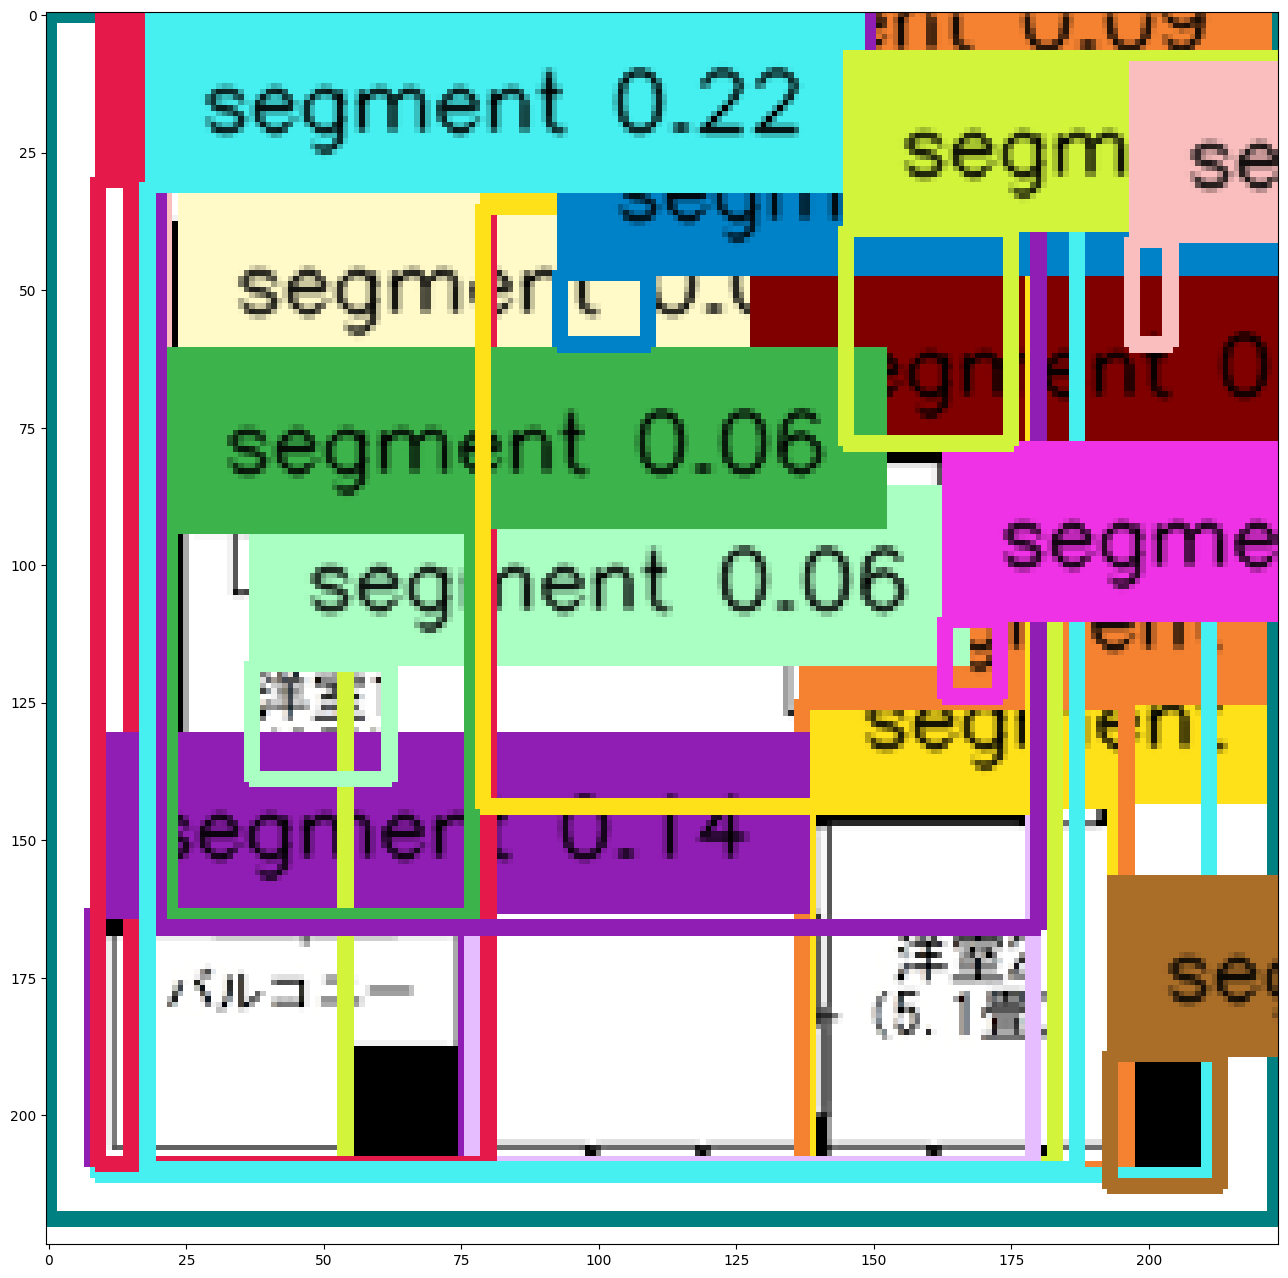

In [139]:
import os
import supervision as sv
IMAGE_NAME = "/content/madori002.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "segment"  # region, segment
BOX_TRESHOLD = 0.05 # 0.05~0.1 -> 部品点数とか図面の密度に応じている.
TEXT_TRESHOLD = 0.05  # 0.05~0.1

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=detection_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

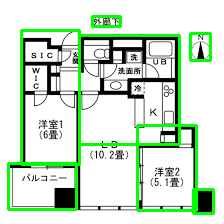

In [140]:
merge_post_boxes = postprocess_for_downstream_task_fine(boxes, 0.7, 0.7)
region_box = []
for post_box_id in range(len(merge_post_boxes)):
    post_box = merge_post_boxes[post_box_id]
    img = cv2.imread(IMAGE_PATH)
    h, w = img.shape[:2]
    xmin = int(w * post_box[0] - w * post_box[2] * 0.5)
    xmax = int(w * post_box[0] + w * post_box[2] * 0.5)
    ymin = int(h * post_box[1] - h * post_box[3] * 0.5)
    ymax = int(h * post_box[1] + h * post_box[3] * 0.5)
    region_box.append([xmin, xmax, ymin, ymax])
display_image = cv2.imread(IMAGE_NAME)

for b in region_box:
  cv2.rectangle(display_image, (b[0], b[2]), (b[1], b[3]), (0, 255, 0), 2)

display(Image.fromarray(display_image))

In [ ]:
# 重なりまくってしまっている部分があるのでnmsで処理する必要がありそう
# 解像度への依存度がすごい気がする。。

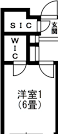

In [83]:
region_id = 3
region_bbox = region_box[region_id]
crop_image = cv2.imread(IMAGE_NAME)[region_bbox[2]:region_bbox[3], region_bbox[0]:region_bbox[1], :]
cv2.imwrite("temp.jpg", crop_image)
display(Image.fromarray(crop_image))

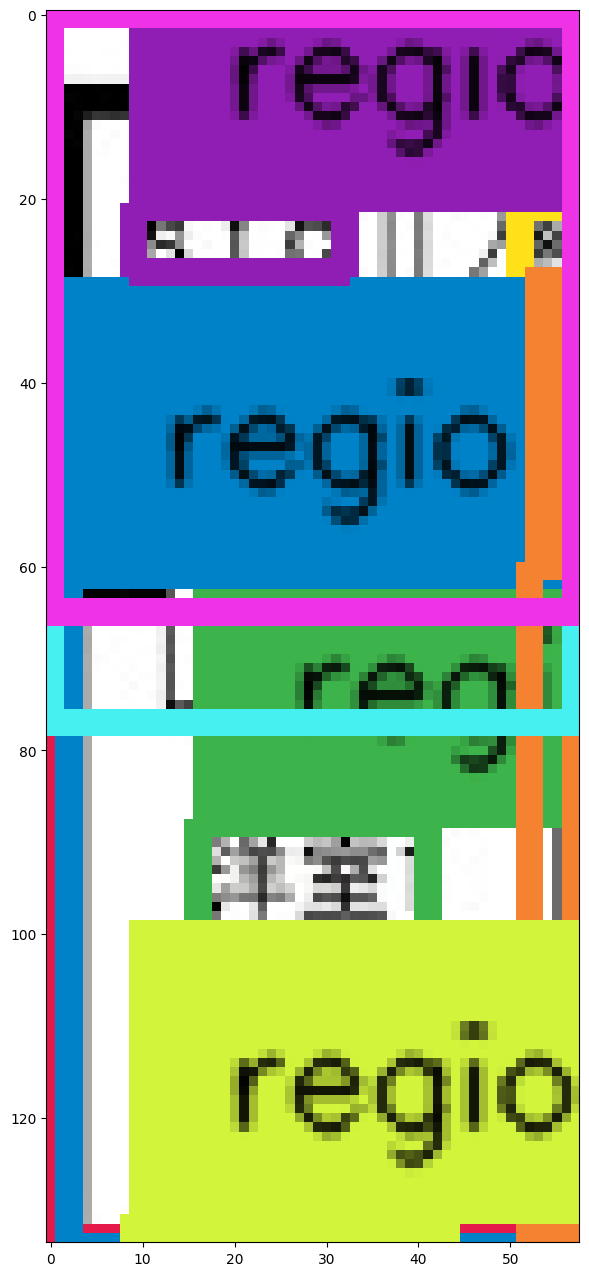

In [84]:
# 2 stage inference
CROP_IMAGE_NAME = "temp.jpg"

TEXT_PROMPT = "region"  # rectangle, region, shape region, segment, fragment
BOX_TRESHOLD = 0.1 # 0.05~0.1 -> 部品点数とか図面の密度に応じている.
TEXT_TRESHOLD = 0.1  # 0.05~0.1

image_source, image = load_image(CROP_IMAGE_NAME)

crop_boxes, crop_logits, crop_phrases = predict(
    model=detection_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=crop_boxes, logits=crop_logits, phrases=crop_phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

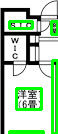

In [85]:
crop_merge_post_boxes = postprocess_for_downstream_task_fine(crop_boxes, 0.9, 0.9)
crop_region_box = []
for post_box_id in range(len(crop_merge_post_boxes)):
    post_box = crop_merge_post_boxes[post_box_id]
    img = cv2.imread(CROP_IMAGE_NAME)
    h, w = img.shape[:2]
    xmin = int(w * post_box[0] - w * post_box[2] * 0.5)
    xmax = int(w * post_box[0] + w * post_box[2] * 0.5)
    ymin = int(h * post_box[1] - h * post_box[3] * 0.5)
    ymax = int(h * post_box[1] + h * post_box[3] * 0.5)
    crop_region_box.append([xmin, xmax, ymin, ymax])

display_image = cv2.imread(CROP_IMAGE_NAME)

for b in crop_region_box:
  cv2.rectangle(display_image, (b[0], b[2]), (b[1], b[3]), (0, 255, 0), 2)

display(Image.fromarray(display_image))

text pipeline

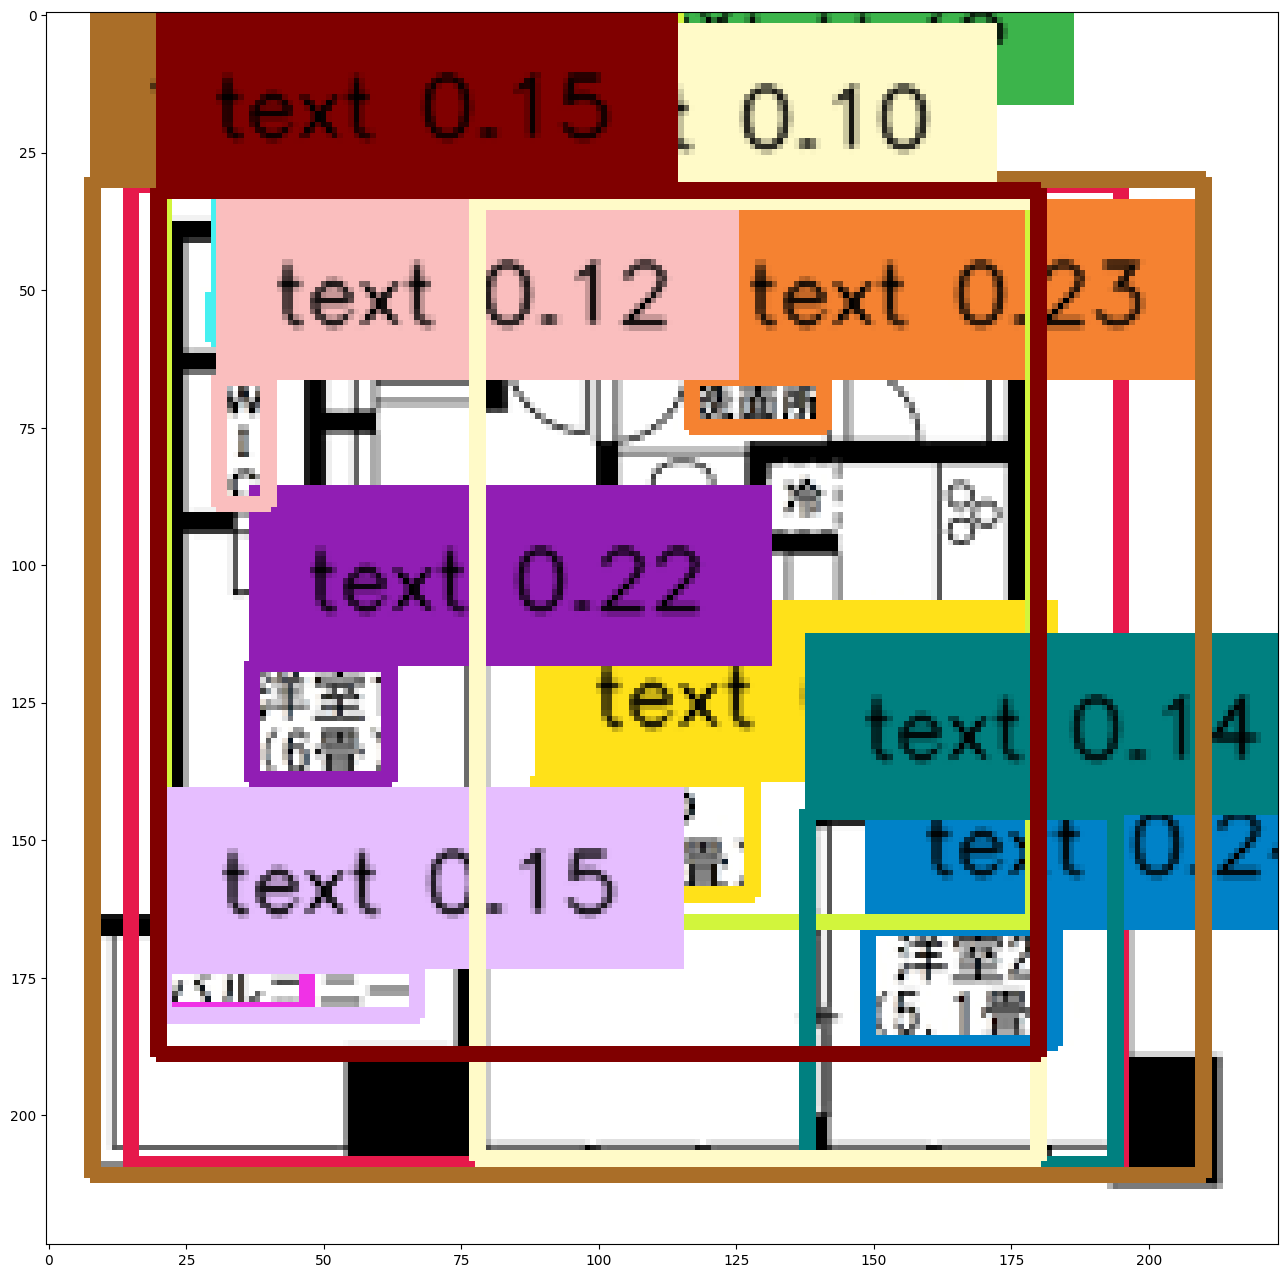

In [91]:
# ここのテキスト抽出の部分はgoogle cloud vision apiでやる方が精度がいい。。
# https://cloud.google.com/vision?hl=ja
import os
import supervision as sv
IMAGE_NAME = "/content/madori002.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

TEXT_PROMPT = "text"  # region, segment
BOX_TRESHOLD = 0.1 # 0.05~0.1 -> 部品点数とか図面の密度に応じている.
TEXT_TRESHOLD = 0.1  # 0.05~0.1

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=detection_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline  
sv.plot_image(annotated_frame, (16, 16))

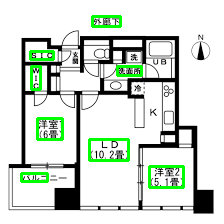

In [100]:
merge_post_boxes = postprocess_for_downstream_task_fine(boxes, 0.2, 0.2)
region_box = []
for post_box_id in range(len(merge_post_boxes)):
    post_box = merge_post_boxes[post_box_id]
    img = cv2.imread(IMAGE_PATH)
    h, w = img.shape[:2]
    xmin = int(w * post_box[0] - w * post_box[2] * 0.5)
    xmax = int(w * post_box[0] + w * post_box[2] * 0.5)
    ymin = int(h * post_box[1] - h * post_box[3] * 0.5)
    ymax = int(h * post_box[1] + h * post_box[3] * 0.5)
    region_box.append([xmin, ymin, xmax, ymax])
display_image = cv2.imread(IMAGE_NAME)

for b in region_box:
  cv2.rectangle(display_image, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)

display(Image.fromarray(display_image))

In [93]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [97]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [ ]:
image = cv2.imread(IMAGE_NAME)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for rb in region_box:
  image[rb[1]:rb[3], rb[0]:rb[2], :] = 255
display(Image.fromarray(image))

In [126]:
predictor.set_image(image)

In [127]:
middle_point = []
for rb in region_box:
  middle_point.append([int(rb[0] * 0.5 + rb[2] * 0.5), int(rb[1] * 0.5 + rb[3] * 0.5)])

In [ ]:
# 小さな部屋なら上手く行きそう。

In [134]:
idx = 3
label_list = [0 for i in range(len(middle_point))]
label_list[idx] = 1
input_point = np.array(middle_point)
input_label = np.array(label_list)

In [135]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

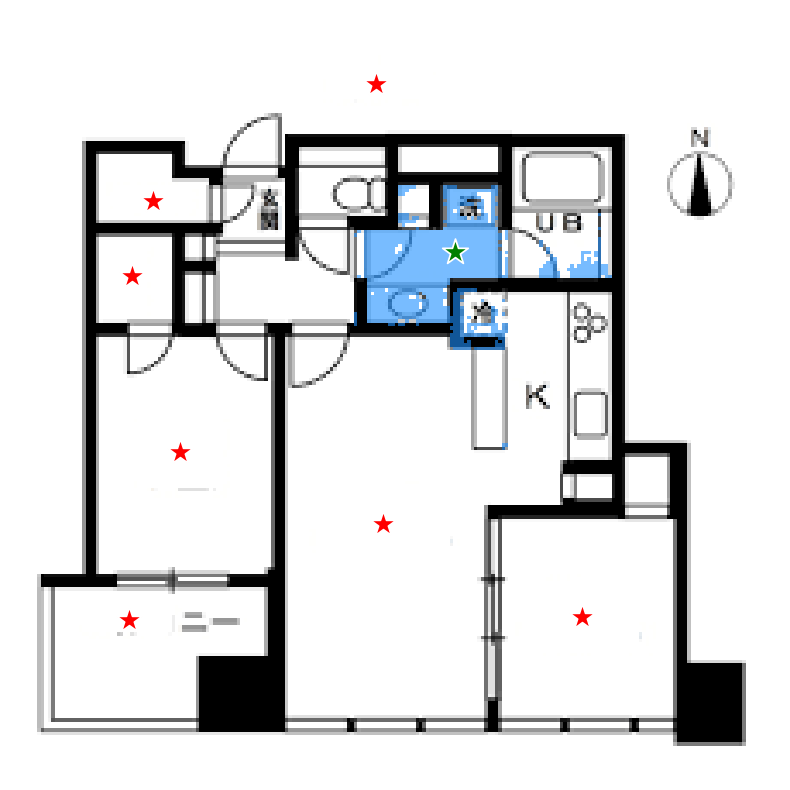

In [136]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 